In [1]:
# general impors
import os
import re
from termcolor import colored

# ocr imports
import pytesseract
import cv2 as cv
import pymupdf 
from fitz import open as fitz_open

# db management imports
import pymongo
import requests

# dotenv imports
from dotenv import load_dotenv
load_dotenv()

True

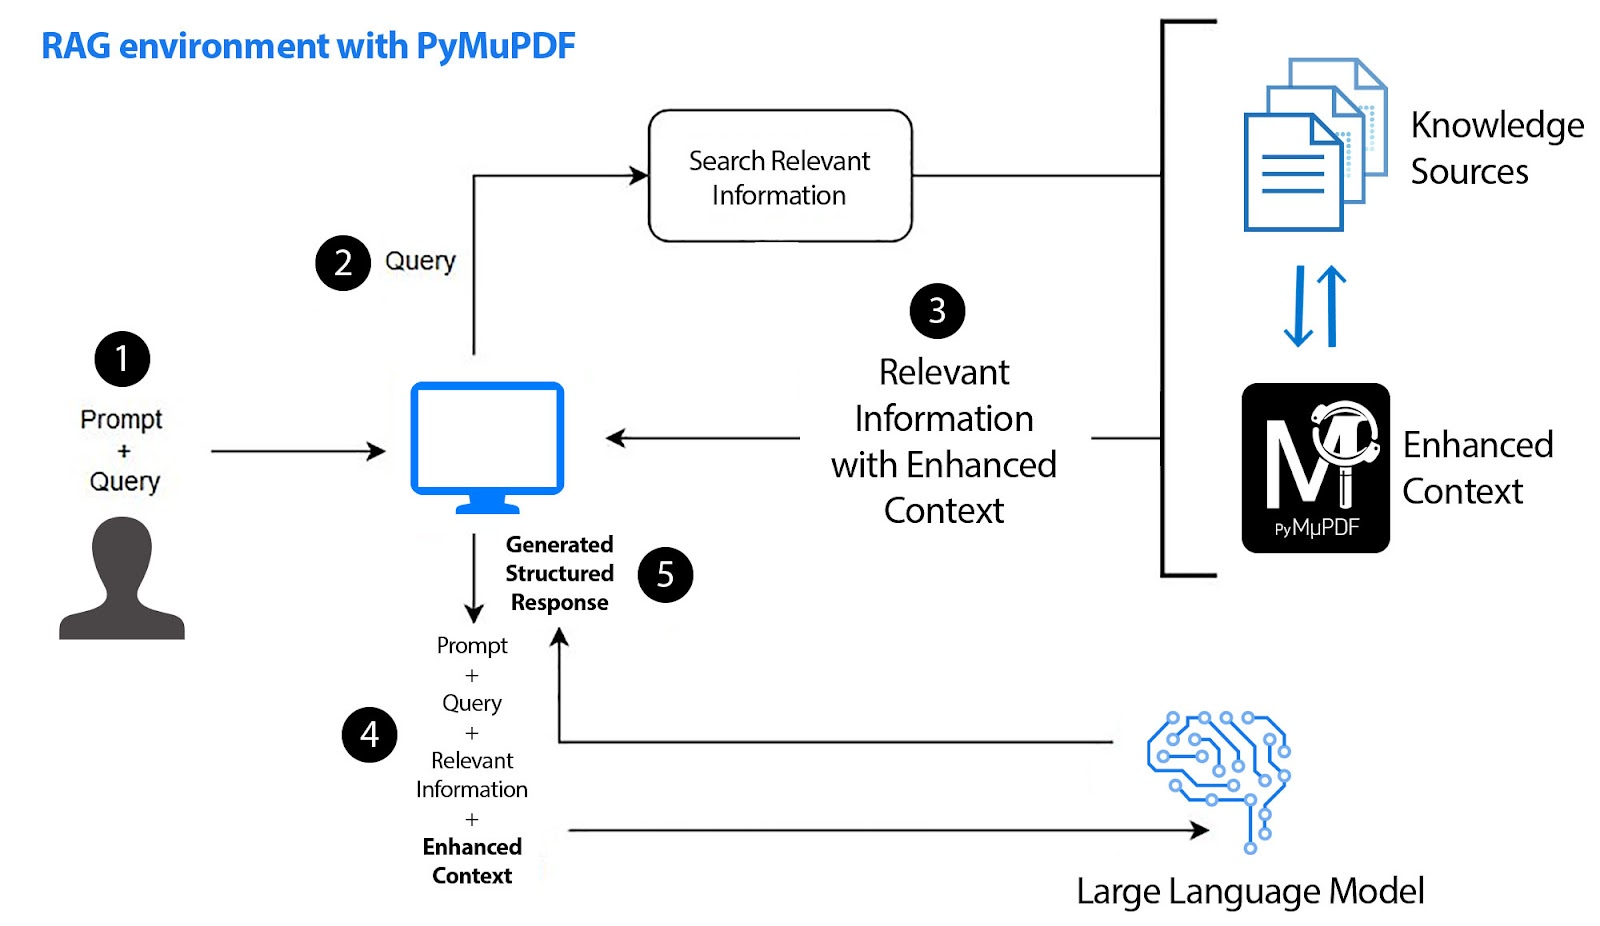

-----------------------------------

#### <span style="color:yellow"> all-MiniLM-L6-v2 </span> is a sentence-transformers model. It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

------------------------------------

#### Set APIs Keys and HuggingFace Tokens

In [2]:
## MongoDB Setup
my_client = os.getenv('MONGO_URI')
client = pymongo.MongoClient(my_client)
db = client.Loaded_Text
collection = db.filesText


## Huggingface API Setup
huggingface_tk = os.getenv('huggingface_tk')
embedding_url = "https://api-inference.huggingface.co/pipeline/feature-extraction/sentence-transformers/all-MiniLM-L6-v2"

hf_token = huggingface_tk

In [24]:
directory = "static"
files = [file for file in os.listdir(directory) if file.endswith(".pdf")]


for i, file in enumerate(files):
    print(f"File: {i}")
    print(f"--> {file}\n-------")

File: 0
--> A PlusCal User's Manual - C-Syntax Version 1.8 (31 Aug 2018).pdf
-------
File: 1
--> AEWC Follow up 2019 - Requests to the Management.pdf
-------
File: 2
--> fors_policybrief_genderequality_2010.pdf
-------
File: 3
--> Investigation of Hardware Transactional Memory - 2015 (Andrew-Nguyen-Thesis).pdf
-------
File: 4
--> ssrn-1014233.pdf
-------
File: 5
--> TIE_W05_ReuterTruman.pdf
-------


In [25]:
full_json = dict()

def parse_file(filepath, fileName):
  """ 
  Parse a PDF file and return a dictionary with the text of each page.
  """

  blocks = ""

  pdf = fitz_open(filepath)

  file_json = dict()
  file_json[f"FILE: {fileName}"] = [] 

  for i, page in enumerate(pdf): 
    blocks = page.get_text(sort=True).replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').strip()

    replacements = [("\.+", ""), ("\s+", " ")]
    for pat, repl in replacements:
      blocks = re.sub(pattern=pat, repl=repl, string= blocks)
    
    blocks += blocks

    file_json[f"FILE: {fileName}"] = blocks

  pdf.close()

  return file_json

In [26]:
for file in files:
    filepath = os.path.join(directory, file)
    fileName = file.split(".")[0]

    file_json = parse_file(filepath, fileName)
    full_json.update(file_json)

In [29]:
for parsed in full_json:
    print(parsed)
    print("------------------------")

FILE: A PlusCal User's Manual - C-Syntax Version 1
------------------------
FILE: AEWC Follow up 2019 - Requests to the Management
------------------------
FILE: fors_policybrief_genderequality_2010
------------------------
FILE: Investigation of Hardware Transactional Memory - 2015 (Andrew-Nguyen-Thesis)
------------------------
FILE: ssrn-1014233
------------------------
FILE: TIE_W05_ReuterTruman
------------------------


In [3]:
def generate_embedding(text: str) -> list[float]:

    """ 
    Set up the embedding creation function
    """

    response = requests.post(
        embedding_url, 
        headers={
            "Authorization": f"Bearer {hf_token}"},
            json={"inputs": text, 
            "options":{"wait_for_model":True}}
            )

    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}: {response.text}")

    return response.json()

## Write data onn database

In [32]:
for k,v in full_json.items():
    collection.insert_one({"documentName": k, "text": v})

## Write embedded data on database

In [34]:
# replace data in-place

for doc in collection.find({'text': {"$exists": True}}).limit(50):
    doc['hf_text_embedding'] = generate_embedding(doc['text'])
    collection.replace_one({'_id': doc['_id']}, doc)

-------------------------------

#### check if exists

In [31]:
print(collection.find_one({}, {"pages.hf_text_embedding": 1}))

{'_id': ObjectId('67cf080080a7cb5e53af1f66'), 'pages': [{'hf_text_embedding': [-0.06081909313797951, 0.007946429774165154, 0.017972828820347786, -0.005322170443832874, -0.042622730135917664, 0.06054191663861275, 0.04694255441427231, 0.07221008837223053, -0.07548210024833679, 0.08097979426383972, 0.030330384150147438, -0.017413785681128502, -0.011965153738856316, 0.013982713222503662, 0.013098631985485554, 0.007201055996119976, -0.10373914986848831, 0.04238664358854294, 0.01648068241775036, -0.024859638884663582, 0.05337873101234436, -0.06978707015514374, -0.051171399652957916, -0.02100987173616886, 0.011490429751574993, 0.004623180255293846, -0.07246159017086029, 0.028885992243885994, 0.09030640870332718, 0.06427894532680511, -0.06144481524825096, 0.03661426529288292, 0.05380718410015106, 0.05918552726507187, 0.06996781378984451, 0.023907747119665146, -0.004438832867890596, -0.0238001961261034, -0.011252189986407757, -0.008214954286813736, 0.014464501291513443, -0.049588076770305634, 0

------------------------

In [25]:
# query = "___your_keywords_here___"

example_query = "TLC module"


####################################
##  vector search code structure  ##
####################################

# {
#   "$vectorSearch": {
#     "exact": true | false,
#     "filter": {<filter-specification>},
#     "index": "<index-name>",
#     "limit": <number-of-results>,
#     "numCandidates": <number-of-candidates>,
#     "path": "<field-to-search>",
#     "queryVector": [<array-of-numbers>]
#   }
# }

# !!! queryvector is the generated vector from the specific query used. 
# !!! index is the search index created inside MongoDB by the admin.


####################################
####################################

pipeline = [
    {
        "$vectorSearch": {
            "index": "parsedFiles_index",
            "path": "hf_text_embedding",  # e.g., "0.hf_text_embedding"
            "queryVector": generate_embedding(example_query),
            "limit": 4,
            "numCandidates": 100
        }
    }
    
]

results = collection.aggregate(pipeline)

## Where was the word found?

In [26]:
for i, doc in enumerate(results, 1):
    print(f"Documento {i}")
    print(doc['documentName'])
    print("------")

Documento 1
FILE: A PlusCal User's Manual - C-Syntax Version 1
------
Documento 2
FILE: TIE_W05_ReuterTruman
------
Documento 3
FILE: AEWC Follow up 2019 - Requests to the Management
------
Documento 4
FILE: ssrn-1014233
------
